In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Preparing Data

In [ ]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Karawang")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1999-01-12 00:00:00,1,0.281,3.450012
1,1999-01-12 01:00:00,2,0.281,3.195916
2,1999-01-12 02:00:00,3,0.281,3.480425
3,1999-01-12 03:00:00,4,0.234,3.734589
4,1999-01-12 04:00:00,5,0.234,3.478974
...,...,...,...,...
3643,1999-06-12 19:00:00,3644,0.297,4.675316
3644,1999-06-12 20:00:00,3645,0.297,4.597948
3645,1999-06-12 21:00:00,3646,0.250,4.480365
3646,1999-06-12 22:00:00,3647,0.250,4.327907


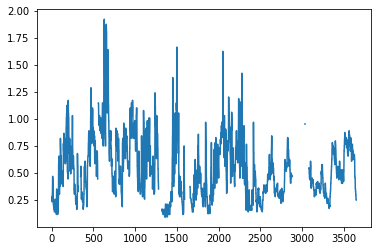

In [ ]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [ ]:
import copy
data_raw = copy.deepcopy(data)

### Interpolation

In [ ]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [ ]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [ ]:
# drop NaN value in dataframe data
data = data.dropna()

In [ ]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [ ]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [ ]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [ ]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [ ]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-13-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-13-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-13-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


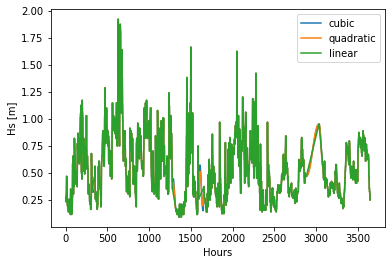

In [ ]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

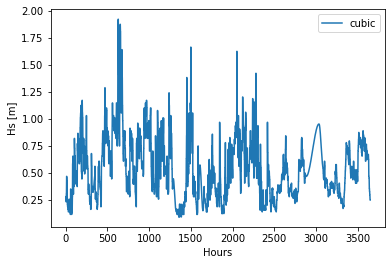

In [ ]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

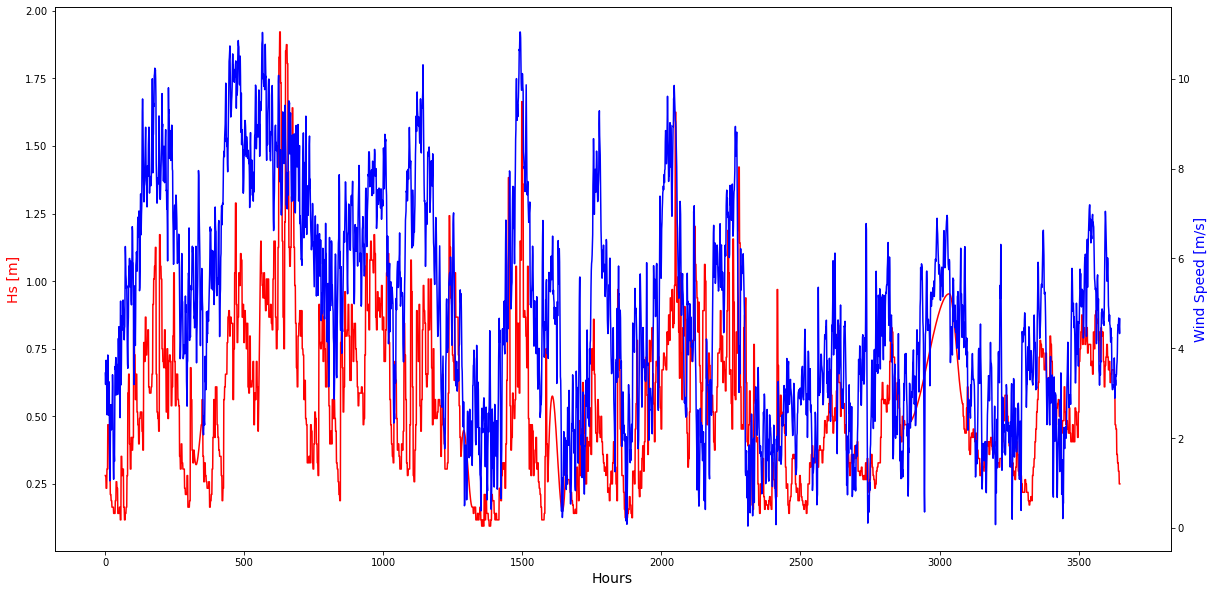

In [ ]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

## Splitting data

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


values = data2.values
values = values[:,2:]
values

array([[0.281, 3.45001248870473],
       [0.281, 3.19591592533671],
       [0.281, 3.48042493449674],
       ...,
       [0.25, 4.48036542736991],
       [0.25, 4.32790717473293],
       [0.25, 4.65317711705861]], dtype=object)

In [ ]:
# ensure all data is float
values = values.astype('float32')

In [ ]:
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# scaled 

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1) #data, window width , output size
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.281,3.450012,0.281,3.195916
2,0.281,3.195916,0.281,3.480425
3,0.281,3.480425,0.234,3.734589
4,0.234,3.734589,0.234,3.478975
5,0.234,3.478975,0.234,3.178940


In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[-1], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var1(t)
1      0.281   3.450012    0.281
2      0.281   3.195916    0.281
3      0.281   3.480425    0.234
4      0.234   3.734589    0.234
5      0.234   3.478975    0.234


In [ ]:
reframed.shape


(3647, 3)

In [ ]:
len(reframed)

3647

In [ ]:
values = reframed.values

In [ ]:
# split into train and test sets
train = values[:round(len(reframed)*0.7), :]
val = values[round(len(reframed)*0.7) : round(len(reframed)*0.8) , :]
test = values[round(len(reframed)*0.8):, :]

In [ ]:
n_hours = 1
n_features = 2
n_obs = n_hours * n_features
X_train1, y_train1 =train[:, :n_obs], train[:, -1]
X_val1, y_val1 = val[:, :n_obs], val[:, -1]
X_test1, y_test1 = test[:, :n_obs], test[:, -1]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((2553, 2), (2553,), (365, 2), (365,), (729, 2), (729,))

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_train1 = X_train1.reshape((X_train1.shape[0],n_hours , n_features))
X_val1 = X_val1.reshape((X_val1.shape[0],n_hours,n_features))
X_test1 = X_test1.reshape((X_test1.shape[0], n_hours, n_features))
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((2553, 1, 2), (2553,), (365, 1, 2), (365,), (729, 1, 2), (729,))

## Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((1, 2)))
model1.add(LSTM(96))
model1.add(Dense(1, 'sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96)                38016     
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 38,113
Trainable params: 38,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
77/80 [===========================>..] - ETA: 0s - loss: 0.1074 - root_mean_squared_error: 0.3277

80/80 [==============================] - 11s 79ms/step - loss: 0.1065 - root_mean_squared_error: 0.3263 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 2/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0942 - root_mean_squared_error: 0.3069 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1580
Epoch 3/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0878 - root_mean_squared_error: 0.2963 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0842 - root_mean_squared_error: 0.2901 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1659
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0816 - root_mean_squared_error: 0.2857 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1651
Epoch 6/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0793 - root_mean_squared_error: 0.2816 - val_loss: 0.0262 - val_root_mean_square

80/80 [==============================] - 7s 85ms/step - loss: 0.0697 - root_mean_squared_error: 0.2641 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459
Epoch 11/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.2590

80/80 [==============================] - 5s 68ms/step - loss: 0.0672 - root_mean_squared_error: 0.2592 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1415
Epoch 12/100
78/80 [============================>.] - ETA: 0s - loss: 0.0651 - root_mean_squared_error: 0.2551

80/80 [==============================] - 7s 91ms/step - loss: 0.0646 - root_mean_squared_error: 0.2541 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1360
Epoch 13/100
80/80 [==============================] - ETA: 0s - loss: 0.0620 - root_mean_squared_error: 0.2489

80/80 [==============================] - 5s 64ms/step - loss: 0.0620 - root_mean_squared_error: 0.2489 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 14/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0593 - root_mean_squared_error: 0.2436

80/80 [==============================] - 7s 91ms/step - loss: 0.0593 - root_mean_squared_error: 0.2435 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1284
Epoch 15/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0570 - root_mean_squared_error: 0.2387

80/80 [==============================] - 5s 67ms/step - loss: 0.0567 - root_mean_squared_error: 0.2381 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1231
Epoch 16/100
78/80 [============================>.] - ETA: 0s - loss: 0.0543 - root_mean_squared_error: 0.2329

80/80 [==============================] - 7s 83ms/step - loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 17/100
73/80 [==========================>...] - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.2301

80/80 [==============================] - 7s 85ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 18/100
79/80 [============================>.] - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.2218

80/80 [==============================] - 6s 80ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 19/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.2175

80/80 [==============================] - 6s 77ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 20/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.2111

80/80 [==============================] - 5s 65ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 21/100
78/80 [============================>.] - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.2067

80/80 [==============================] - 7s 93ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 22/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0405 - root_mean_squared_error: 0.2011

80/80 [==============================] - 6s 71ms/step - loss: 0.0402 - root_mean_squared_error: 0.2006 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 23/100
78/80 [============================>.] - ETA: 0s - loss: 0.0386 - root_mean_squared_error: 0.1964

80/80 [==============================] - 6s 81ms/step - loss: 0.0383 - root_mean_squared_error: 0.1958 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0982
Epoch 24/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0367 - root_mean_squared_error: 0.1916

80/80 [==============================] - 6s 70ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 25/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0348 - root_mean_squared_error: 0.1865

80/80 [==============================] - 6s 82ms/step - loss: 0.0348 - root_mean_squared_error: 0.1864 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 26/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0331 - root_mean_squared_error: 0.1820

80/80 [==============================] - 7s 88ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911
Epoch 27/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0318 - root_mean_squared_error: 0.1782

80/80 [==============================] - 5s 67ms/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 28/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0299 - root_mean_squared_error: 0.1728

80/80 [==============================] - 6s 79ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 29/100
78/80 [============================>.] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1702

80/80 [==============================] - 6s 79ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 30/100
80/80 [==============================] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.1661

80/80 [==============================] - 7s 83ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 31/100
72/80 [==========================>...] - ETA: 0s - loss: 0.0271 - root_mean_squared_error: 0.1645

80/80 [==============================] - 6s 74ms/step - loss: 0.0264 - root_mean_squared_error: 0.1626 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 32/100
80/80 [==============================] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1594

80/80 [==============================] - 6s 77ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 33/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0248 - root_mean_squared_error: 0.1576

80/80 [==============================] - 6s 82ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 34/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 35/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0222 - root_mean_squared_error: 0.1489

80/80 [==============================] - 7s 88ms/step - loss: 0.0228 - root_mean_squared_error: 0.1508 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 36/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1497

80/80 [==============================] - 6s 76ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656
Epoch 37/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 38/100
80/80 [==============================] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.1441

80/80 [==============================] - 5s 67ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 39/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0203 - root_mean_squared_error: 0.1426

80/80 [==============================] - 7s 94ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 40/100
73/80 [==========================>...] - ETA: 0s - loss: 0.0202 - root_mean_squared_error: 0.1420

80/80 [==============================] - 6s 74ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 41/100
79/80 [============================>.] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1398

80/80 [==============================] - 6s 81ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 42/100
73/80 [==========================>...] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1384

80/80 [==============================] - 5s 63ms/step - loss: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 43/100
70/80 [=========================>....] - ETA: 0s - loss: 0.0183 - root_mean_squared_error: 0.1351

80/80 [==============================] - 8s 95ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 44/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1346

80/80 [==============================] - 6s 72ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 45/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 46/100
70/80 [=========================>....] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1344

80/80 [==============================] - 6s 73ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 47/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.1348

80/80 [==============================] - 6s 74ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 48/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 49/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 50/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1333

80/80 [==============================] - 7s 83ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 51/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 52/100
80/80 [==============================] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.1322

80/80 [==============================] - 7s 87ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 53/100
79/80 [============================>.] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.1321

80/80 [==============================] - 7s 87ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 54/100
80/80 [==============================] - 1s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 55/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1309

80/80 [==============================] - 6s 71ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 56/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 57/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 58/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 59/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 60/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0018 - val_root_mean_sq

80/80 [==============================] - 7s 88ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 62/100
79/80 [============================>.] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.1314

80/80 [==============================] - 6s 70ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 63/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 64/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 65/100
70/80 [=========================>....] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.1316

80/80 [==============================] - 7s 84ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 66/100
80/80 [==============================] - 1s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 67/100
80/80 [==============================] - 1s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 68/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1331

80/80 [==============================] - 6s 70ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 69/100
80/80 [==============================] - 0s 5ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 70/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 71/100
73/80 [==========================>...] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1307

80/80 [==============================] - 6s 82ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 72/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0394
Epoch 73/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 74/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 75/100
80/80 [==============================] - 1s 6ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 76/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0015 - val_root_mean_sq

80/80 [==============================] - 5s 69ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 87/100
78/80 [============================>.] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1307

80/80 [==============================] - 7s 84ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 88/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 89/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 90/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 91/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 92/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0014 - val_root_mean_sq

80/80 [==============================] - 7s 93ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 98/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 99/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 100/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Multivariate':train_predictions, 'Actuals':y_train1})
train_results

80/80 [==============================] - 1s 2ms/step


,Multivariate,Actuals
0,0.274354,0.281
1,0.276668,0.281
2,0.274097,0.234
3,0.235421,0.234
4,0.237847,0.234
...,...,...
2548,0.335519,0.328
2549,0.336164,0.328
2550,0.334523,0.328
2551,0.329801,0.328


In [ ]:
# # invert scalling 
# inv_train_results = scaler.inverse_transform(train_results)
# inv_train_results = pd.DataFrame(inv_train_results )
# inv_train_results 

In [ ]:
# # change the column name
# inv_train_results.columns = ['Train Predictions', 'Actuals']
# inv_train_results

In [ ]:
train_results['Date'] = data2['Date'].iloc[:round(len(values)*0.7)]
train_results.head()

,Multivariate,Actuals,Date
0,0.274354,0.281,1999-01-12 00:00:00
1,0.276668,0.281,1999-01-12 01:00:00
2,0.274097,0.234,1999-01-12 02:00:00
3,0.235421,0.234,1999-01-12 03:00:00
4,0.237847,0.234,1999-01-12 04:00:00


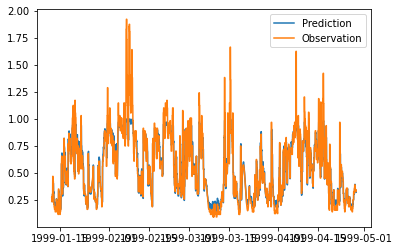

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Date'],train_results['Multivariate'], label ='Prediction')
plt.plot(train_results['Date'],train_results['Actuals'], label='Observation')
plt.legend(loc='best')

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_results['Date'], y=train_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Training'))
fig.add_trace(go.Scatter(x=train_results['Date'], y=train_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Multivariate':val_predictions, 'Actuals':y_val1})
val_results.head()

12/12 [==============================] - 0s 3ms/step


,Multivariate,Actuals
0,0.335579,0.344
1,0.338800,0.344
2,0.342941,0.359
3,0.357374,0.359
4,0.368643,0.359


In [ ]:
val_results['Date'] = data2['Date'].iloc[round(len(reframed)*0.7):round(len(reframed)*0.8)].values
val_results.head()

,Multivariate,Actuals,Date
0,0.335579,0.344,1999-04-28 09:00:00
1,0.338800,0.344,1999-04-28 10:00:00
2,0.342941,0.359,1999-04-28 11:00:00
3,0.357374,0.359,1999-04-28 12:00:00
4,0.368643,0.359,1999-04-28 13:00:00


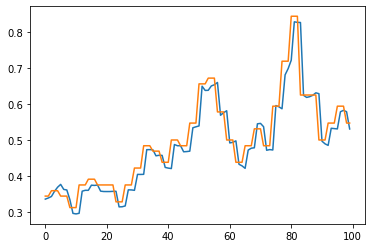

In [ ]:
plt.plot(val_results['Multivariate'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=val_results['Date'], y=val_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Validation'))
fig.add_trace(go.Scatter(x=val_results['Date'], y=val_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Multivariate':test_predictions, 'Actuals':y_test1})
test_results.head()

23/23 [==============================] - 0s 4ms/step


,Multivariate,Actuals
0,0.536383,0.542711
1,0.537887,0.546308
2,0.539163,0.549968
3,0.545060,0.553689
4,0.549854,0.557470


In [ ]:
test_results['Date'] = data2['Date'].iloc[round(len(reframed)*0.8):round(len(reframed))].values
test_results.head()

,Multivariate,Actuals,Date
0,0.536383,0.542711,1999-05-13 14:00:00
1,0.537887,0.546308,1999-05-13 15:00:00
2,0.539163,0.549968,1999-05-13 16:00:00
3,0.545060,0.553689,1999-05-13 17:00:00
4,0.549854,0.557470,1999-05-13 18:00:00


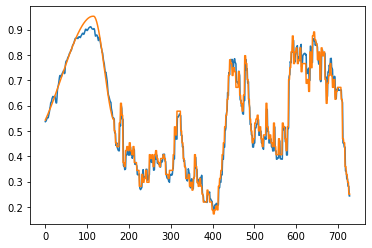

In [ ]:
plt.plot(test_results['Multivariate'])
plt.plot(test_results['Actuals'])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [ ]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Multivariate'])
RMSE = math.sqrt(MSE)
RMSE

0.033987602267000976

In [ ]:

from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Multivariate'])
corr

0.9869298283453605

In [ ]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Multivariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.004444325105152994

In [ ]:
train_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_train_lstm_karawang.csv')
val_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_val_lstm_karawang.csv')
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_test_lstm_karawang.csv')

In [ ]:
# serialize weights to HDF5
model1.save_weights("/content/drive/MyDrive/TA (1)/Learn to Code ML/Model/model_multivariate_karawang.h5")
print("Model Saved !")